In [16]:
# %load /Users/shleifer/durbango/imports.py
#IMPORTS

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ISO = "ISO-8859-1"

import os
import pickle
from tqdm import tqdm, tqdm_notebook, tnrange
import numpy as np
import pandas as pd
import gc
import IPython
import sys

from sklearn.metrics import *
import itertools
from collections import *
from tqdm import tqdm, tqdm_notebook
import funcy
import matplotlib.pyplot as plt
from time import time
from sklearn.linear_model import *
from functools import partial
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, KFold, ParameterGrid
from sklearn.utils import shuffle
from numpy.testing import assert_array_equal
from pandas.testing import assert_frame_equal, assert_series_equal, assert_index_equal
from sklearn.preprocessing import StandardScaler, RobustScaler
from pathlib import Path, PosixPath
import re
from glob import glob
import gzip
#from pandas_summary import DataFrameSummary
import pickle
from IPython.lib.display import FileLink

mock_arr = np.array(range(25)).reshape(5,5)
mock_df = pd.DataFrame(np.ones((5,5)), columns=['a', 'b', 'c', 'd', 'e'])
mock_df['color'] = ['red', 'blue', 'red', 'blue', 'green']
mock_df['bool_col'] = [True, False, True, False, True]


np.set_printoptions(precision=5, linewidth=110, suppress=True)

from ipykernel.kernelapp import IPKernelApp
def in_notebook(): return IPKernelApp.initialized()
def printmd(string):
    display(Markdown(string))
from IPython.display import Markdown, display, HTML
from IPython.core.interactiveshell import InteractiveShell

display(HTML("<style>.container { width:90% !important; }</style>"))

# pretty print only the last output of the cell
# InteractiveShell.ast_node_interactivity = "last_expr" # "all" for all
try:
    import eli5
    from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
    import seaborn as sns
except ImportError:
    pass
def pickle_save(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
def pickle_load_gzip(path):
    with gzip.open(path, 'rb') as f:
        return pickle.load(f, encoding='latin-1')
def pickle_load(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
save_pickle = pickle_save
load_pickle = pickle_load


Path.ls =  property(lambda self: list(self.iterdir()))
ParameterGrid.l = property(lambda self: list(self))

to_arr = lambda x: x.detach().numpy()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from fastai.imagito.analysis import *
import seaborn as sns
# FIX THIS
experiment_dir = Path('/Users/shleifer/fastai-fork/experiments')


In [15]:
metric_df, param_df = read_results(experiment_dir)

<class 'pandas.errors.EmptyDataError'>: /Users/shleifer/fastai-fork/experiments/2019-05-31-07:14:21
<class 'FileNotFoundError'>: /Users/shleifer/fastai-fork/experiments/2019-05-31-00:09:07
<class 'FileNotFoundError'>: /Users/shleifer/fastai-fork/experiments/2019-05-30-16:03:19
<class 'FileNotFoundError'>: /Users/shleifer/fastai-fork/experiments/2019-05-31-00:47:43
<class 'FileNotFoundError'>: /Users/shleifer/fastai-fork/experiments/2019-05-14-04:02:56



In [17]:
df = combine(metric_df, param_df)
df = df.fillna({'label_smoothing': True, 'ds_path': 'imagenette', 'hardness_lower_bound':0,
                'hardness_upper_bound':1., 'flip_lr_p': 0.5,
               })#.drop(['top_k_accuracy', 1])

n_experiments: 533


In [19]:
%%capture
df['_hardness_str'] = df.apply(lambda r: f'hard-{r.hardness_lower_bound}-{r.hardness_upper_bound}', 1)
DEFAULT_HARD_STR = 'hard-0.0-1.0'
df['classes'] = df['classes'].replace({'0-10': 'All Classes', '0-4': 'Half Classes', '5-9': 'Other Half Classes',
                                      '0-1': '2Classes'})
df['seconds'] = df['time'].str.split(':').apply(lambda x: 60*int(x[0])+int(x[1]))
df[STRAT] = df['classes'] + '-' + df['sample'].astype(str)
DS_PATH = 'ds_path'
df['z_acc_epoch'] = df.groupby((STRAT, 'epoch'))['accuracy'].transform(zscore)
df.loc[df[DS_PATH]!= 'imagenette', STRAT] = 'distillation'
df.loc[df['_hardness_str'] != DEFAULT_HARD_STR, STRAT] =  df.loc[df['_hardness_str'] != DEFAULT_HARD_STR, '_hardness_str']

@eric See custom properties like `df.bm_strat` or `df.e19` at top of `analysis.py`. They are handy

In [22]:
assert df.lr.nunique()== df.bm_strat.lr.nunique(), 'Missing lr configs for benchmark'

In [23]:
assert df.groupby(('date', 'epoch')).size().max() == 1

/Users/shleifer/miniconda3/envs/cs231n/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


#### Correlations

In [28]:
DEFAULT_CONFIG_COLS

['size', 'label_smoothing', 'lr', 'flip_lr_p']

In [24]:
cor_tab = make_cor_tab(df.full_train.s128, agg_col=ACCURACY)

/Users/shleifer/miniconda3/envs/cs231n/lib/python3.7/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/shleifer/miniconda3/envs/cs231n/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [27]:
cor_tab.sort_values('N Experiments', ascending=False)

,All Changes,Positive Changes,Best Params,N Experiments
sampling_strat,,,,
hard-0.0-0.1,0.33,0.33,"(128, False, 0.01, 0.5)",33
All Classes-0.5,0.90,0.90,"(128, False, 0.003, 0.25)",28
All Classes-1.0,1.00,1.00,"(128, False, 0.003, 0.25)",28
hard-0.0-0.75,0.95,0.95,"(128, False, 0.007, 0.5)",24
hard-0.75-1.0,0.82,0.82,"(128, False, 0.003, 0.0)",19
hard-0.25-1.0,0.98,0.98,"(128, False, 0.003, 0.25)",19
hard-0.5-1.0,0.95,0.95,"(128, True, 0.01, 0.5)",19
hard-0.9-1.0,0.79,0.79,"(128, False, 0.007, 0.5)",19
All Classes-0.25,0.65,0.65,"(128, True, 0.01, 0.5)",19


### Run Regressions

In [31]:
from fastai.imagito.grouped_regressions import run_grouped_regs
run_grouped_regs(df.full_train.s128)

,coeff,r2,N_configs
sampling_strat,,,
hard-0.0-0.1,0.35,0.12,18
All Classes-0.5,0.91,0.82,18
hard-0.0-0.75,0.66,0.44,15
hard-0.5-1.0,0.94,0.88,18
hard-0.25-1.0,0.98,0.96,18
hard-0.9-1.0,0.80,0.63,18
All Classes-0.7,0.78,0.61,18
All Classes-0.25,0.61,0.37,17
hard-0.75-1.0,0.81,0.66,18


### More in  Depth/But Dirty

In [32]:
exp_df = df.groupby('date').first().assign(accuracy=df.groupby('date').accuracy.max())

In [33]:
exp_df.epochs.value_counts()

20    442
5      20
10     17
1      17
Name: epochs, dtype: int64

In [36]:
bm_df = df.bm_strat

### Comparing partial runs to full runs

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


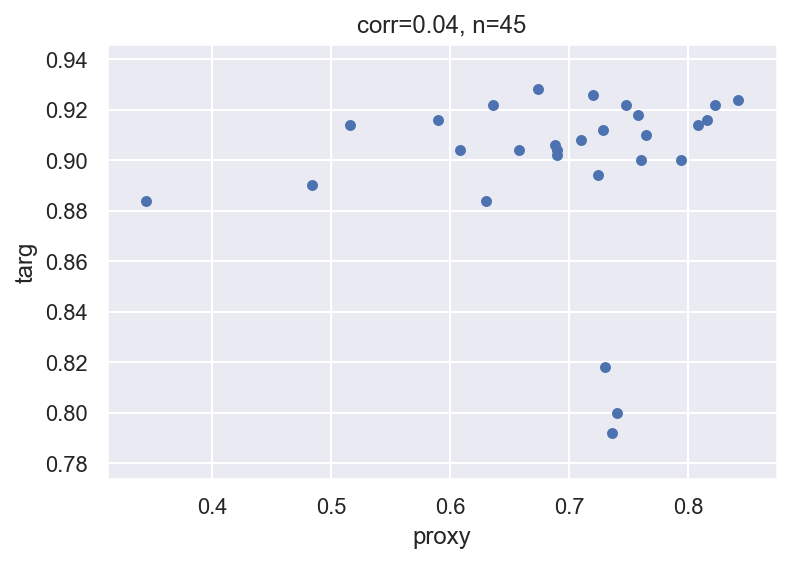

In [40]:
# compare from fucked LR schedule
pl_data = make9_19_data(bm_df.s128, 'accuracy')
#ax = pl_data.plot.scatter(x='ep9', y='ep19')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


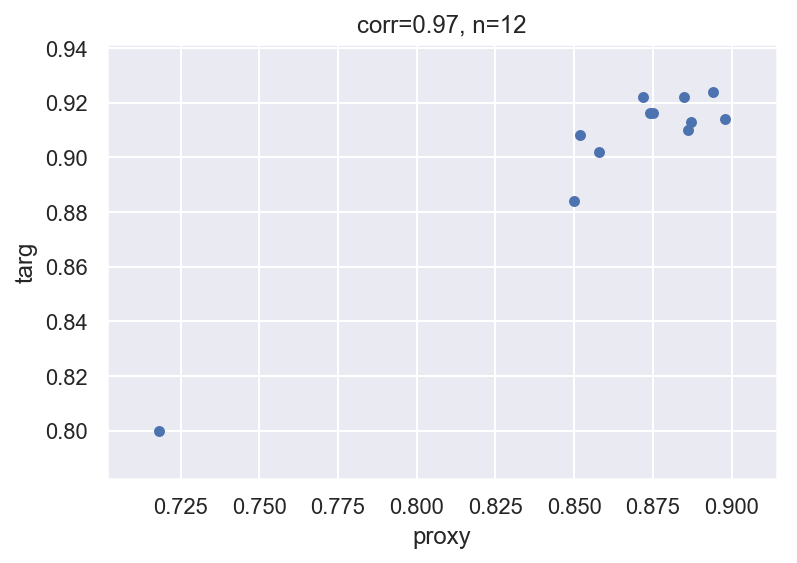

In [41]:
make_9_19_data_fairer(df, ref_epoch=10)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


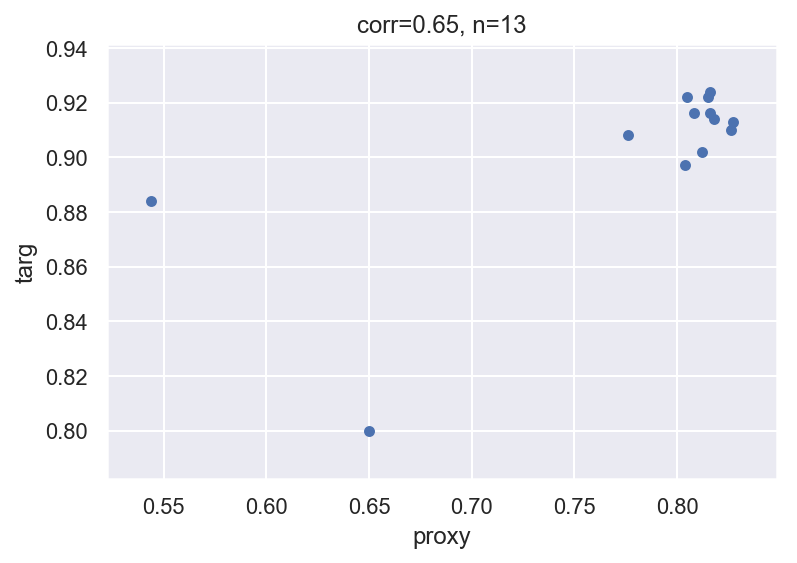

In [42]:
make_9_19_data_fairer(df, ref_epoch=5)

In [50]:
pwd

'/Users/shleifer/fastai-fork/fastai/imagito'

In [44]:
best_pars = df.e19.groupby([STRAT] + DEFAULT_CONFIG_COLS)['accuracy'].median().unstack(level=DEFAULT_CONFIG_COLS)

In [45]:
best_pars.idxmax(1)

sampling_strat
2Classes-0.1               (128, False, 0.003, 0.5)
2Classes-0.5                (128, True, 0.003, 0.5)
2Classes-1.0               (128, False, 0.003, 0.5)
All Classes-0.1             (128, True, 0.003, 0.5)
All Classes-0.25            (256, True, 0.003, 0.5)
All Classes-0.5           (128, False, 0.003, 0.25)
All Classes-0.7            (128, False, 0.015, 0.5)
All Classes-1.0              (256, True, 0.01, 0.5)
Half Classes-0.1           (128, False, 0.003, 0.5)
Half Classes-0.25           (256, True, 0.003, 0.5)
Half Classes-0.5            (256, True, 0.003, 0.5)
Half Classes-0.7            (256, True, 0.001, 0.5)
Half Classes-1.0             (256, True, 0.05, 0.5)
Other Half Classes-1.0      (128, True, 0.003, 0.5)
distillation                  (32, False, 0.1, 0.5)
hard-0.0-0.1                (128, False, 0.01, 0.5)
hard-0.0-0.25              (128, False, 0.003, 0.0)
hard-0.0-0.5               (128, False, 0.003, 0.0)
hard-0.0-0.75              (128, False, 0.007, 0.

In [47]:
from fastai.imagito.analysis import make_change_scatters

### TODO: fix `make_change_scatters`

In [48]:
fg,tab = make_change_scatters(df)
fg;

AttributeError: 'tuple' object has no attribute 'stack'